In [13]:
import io
import os

import pyarrow as pa
import pyarrow.parquet as pq
from PIL import Image
from rich.progress import track

In [14]:
DIRECTORY = "/gdata/cold2/duanyule/datasets/PrismLayersPro/data/"
FILE = "line_draw-00001-of-00010.parquet"

table = pq.read_table(os.path.join(DIRECTORY, FILE))
print(table.schema)

id: string
whole_caption: string
whole_image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
style_category: string
base_caption: string
base_image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
layer_count: int32
layer_00: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
layer_00_caption: string
layer_00_box: list<element: int32>
  child 0, element: int32
layer_00_width_dst: int32
layer_00_height_dst: int32
layer_01: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
layer_01_caption: string
layer_01_box: list<element: int32>
  child 0, element: int32
layer_01_width_dst: int32
layer_01_height_dst: int32
layer_02: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
layer_02_caption: string
layer_02_box: list<element: int32>
  child 0, element: int32
layer_02_width_dst: int32
layer_02_height_dst: int32
layer_0

In [15]:
# Show "id" column
print(table.column("id"))

[
  [
    "000014352",
    "000014353",
    "000014354",
    "000014355",
    "000014356",
    ...
    "000014447",
    "000014448",
    "000014449",
    "000014450",
    "000014451"
  ],
  [
    "000014452",
    "000014453",
    "000014454",
    "000014455",
    "000014456",
    ...
    "000014469",
    "000014470",
    "000014471",
    "000014472",
    "000014473"
  ]
]


In [18]:
ID = "000014352"
row = table.filter(pa.compute.equal(table.column("id"), ID))
# Convert record batch to dictionary
data_dict = row.to_pylist()[0]
# Convert binary data to image
for k, v in data_dict.items():
    # If is binary data, convert to image
    if isinstance(v, dict) and "bytes" in v:
        bytes_io = io.BytesIO(v["bytes"])
        image = Image.open(bytes_io)
        data_dict[k] = image
data_dict

{'id': '000014352',
 'whole_caption': 'This is a line draw style image. The image presents a vibrant and engaging promotional design centered around the theme of Ramadan. The background is a rich, warm brown that evokes a sense of earthiness and tradition, providing a solid foundation for the colorful elements that populate the foreground.\n\nAt the top of the image, a stylized awning in a soft cream color hangs, adorned with decorative scalloped edges. Below the awning, two lanterns dangle, adding a touch of festive charm and hinting at the cultural significance of light during Ramadan. \n\nThe focal point of the image is the text, which is prominently displayed in a playful and bold font. The phrase "Special Offer" is positioned at the top in a smaller size, while the main message, "Ramadhan Sale," is rendered in a large, bright green font that stands out against the brown background. This vibrant color choice conveys a sense of excitement and urgency, drawing the viewer\'s attention

In [19]:
def convert_format(data):
    output = {}
    output["id"] = data["id"]
    output["whole_caption"] = data["whole_caption"]
    output["whole_image"] = data["whole_image"]
    output["style_category"] = data["style_category"]
    output["base_caption"] = data["base_caption"]
    output["base_image"] = data["base_image"]
    output["layer_images"] = []
    output["layer_captions"] = []
    output["layer_boxes"] = []
    for i in range(data["layer_count"]):
        prefix = f"layer_{i:02d}"
        output["layer_images"].append(data[f"{prefix}"])
        output["layer_captions"].append(data[f"{prefix}_caption"])
        output["layer_boxes"].append(data[f"{prefix}_box"])
    return output


converted_data = convert_format(data_dict)
converted_data

{'id': '000014352',
 'whole_caption': 'This is a line draw style image. The image presents a vibrant and engaging promotional design centered around the theme of Ramadan. The background is a rich, warm brown that evokes a sense of earthiness and tradition, providing a solid foundation for the colorful elements that populate the foreground.\n\nAt the top of the image, a stylized awning in a soft cream color hangs, adorned with decorative scalloped edges. Below the awning, two lanterns dangle, adding a touch of festive charm and hinting at the cultural significance of light during Ramadan. \n\nThe focal point of the image is the text, which is prominently displayed in a playful and bold font. The phrase "Special Offer" is positioned at the top in a smaller size, while the main message, "Ramadhan Sale," is rendered in a large, bright green font that stands out against the brown background. This vibrant color choice conveys a sense of excitement and urgency, drawing the viewer\'s attention

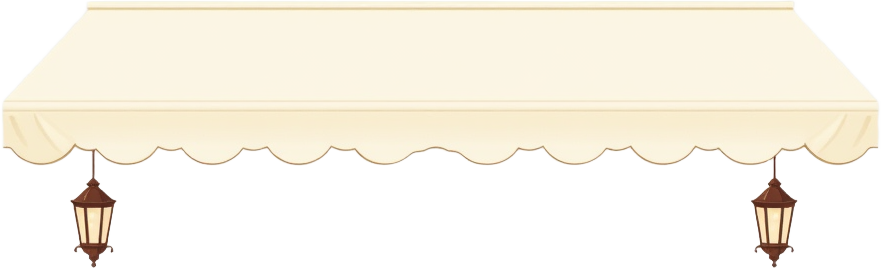

In [20]:
display(converted_data["layer_images"][0])

In [11]:
def generate_index(directory):
    files = os.listdir(directory)
    files = sorted(files)
    index = []
    for file in track(files, description="Generating index"):
        if file.endswith(".parquet"):
            filepath = os.path.join(directory, file)
            table = pq.read_table(filepath, columns=["id"])
            ids = table.column("id").to_pylist()
            for i, id in enumerate(ids):
                index.append({"id": id, "file": file, "row": i})
    return index


index = generate_index(DIRECTORY)
index[:5]  # Show first 5 entries in the index

Output()

[{'id': '000000000', 'file': '3D-00000-of-00002.parquet', 'row': 0},
 {'id': '000000001', 'file': '3D-00000-of-00002.parquet', 'row': 1},
 {'id': '000000002', 'file': '3D-00000-of-00002.parquet', 'row': 2},
 {'id': '000000003', 'file': '3D-00000-of-00002.parquet', 'row': 3},
 {'id': '000000004', 'file': '3D-00000-of-00002.parquet', 'row': 4}]

In [12]:
len(index)

20046